# Import Libraries and Load Data

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
sns.set_style("whitegrid")

# Load the cleaned data
def parse_date(date_str):
    date_str = date_str.strip('"')
    try:
        return pd.to_datetime(date_str, format='%d-%b-%y')
    except ValueError:
        pass
    try:
        return pd.to_datetime(date_str, format='%b %d, %Y')
    except ValueError:
        pass
    return pd.to_datetime(date_str)

data = pd.read_csv('../data/raw/BrentOilPrices.csv', parse_dates=['Date'], date_parser=parse_date)
data = data.dropna().sort_values('Date').reset_index(drop=True)
print(f"Loaded {len(data)} records from {data['Date'].min().date()} to {data['Date'].max().date()}")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.


Loaded 9011 records from 1987-05-20 to 2022-11-14


# Calculate Log Returns and Prepare Data

In [4]:
# Calculate log returns
data['Returns'] = np.log(data['Price'] / data['Price'].shift(1))
returns_data = data.dropna().reset_index(drop=True)

# Prepare time index and values
time_index = np.arange(len(returns_data))
values = returns_data['Returns'].values
dates = returns_data['Date']

# Visualize Returns and Volatility

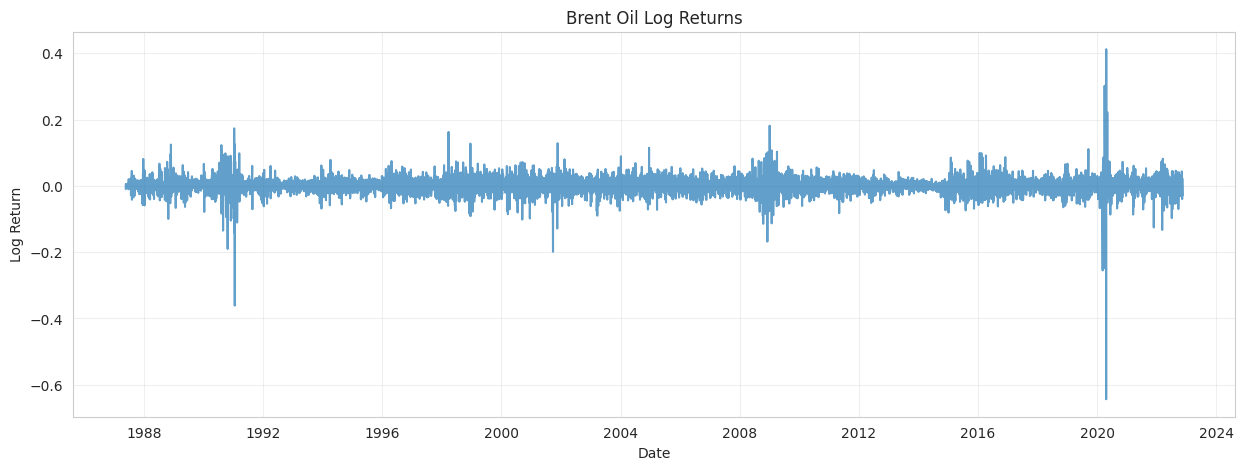

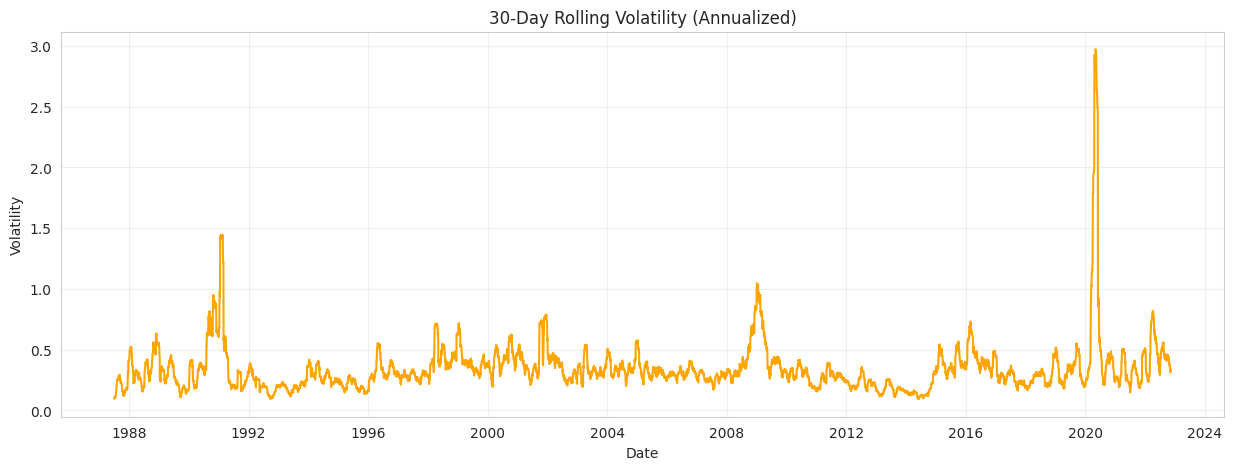

In [5]:
# Plot log returns
plt.figure(figsize=(15, 5))
plt.plot(returns_data['Date'], returns_data['Returns'], alpha=0.7)
plt.title('Brent Oil Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True, alpha=0.3)
plt.show()

# Plot rolling volatility
rolling_vol = returns_data['Returns'].rolling(window=30).std() * np.sqrt(252)
plt.figure(figsize=(15, 5))
plt.plot(returns_data['Date'], rolling_vol, color='orange')
plt.title('30-Day Rolling Volatility (Annualized)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True, alpha=0.3)
plt.show()

# Build and Run the Bayesian Change Point Model


In [6]:
# Alternative Step 3: Statistical Change Point Detection
from scipy import stats
import numpy as np

def detect_change_point(data, window_size=50):
    """Simple change point detection using rolling t-test"""
    n = len(data)
    p_values = []
    
    for i in range(window_size, n - window_size):
        before = data[i-window_size:i]
        after = data[i:i+window_size]
        t_stat, p_val = stats.ttest_ind(before, after)
        p_values.append(p_val)
    
    # Find the point with minimum p-value
    min_p_idx = np.argmin(p_values) + window_size
    return min_p_idx, p_values[min_p_idx]

# Use a subset for faster computation
subset_size = 1000
values_subset = values[:subset_size]
dates_subset = dates[:subset_size]

print(f"Using subset of {subset_size} data points for change point detection")

# Detect change point
change_idx, p_value = detect_change_point(values_subset)
change_date = dates_subset.iloc[change_idx]

print(f"Detected change point at index {change_idx}, date: {change_date.date()}")
print(f"P-value: {p_value:.6f}")

Using subset of 1000 data points for change point detection
Detected change point at index 783, date: 1990-06-15
P-value: 0.149990


# Visualize the Change Point 

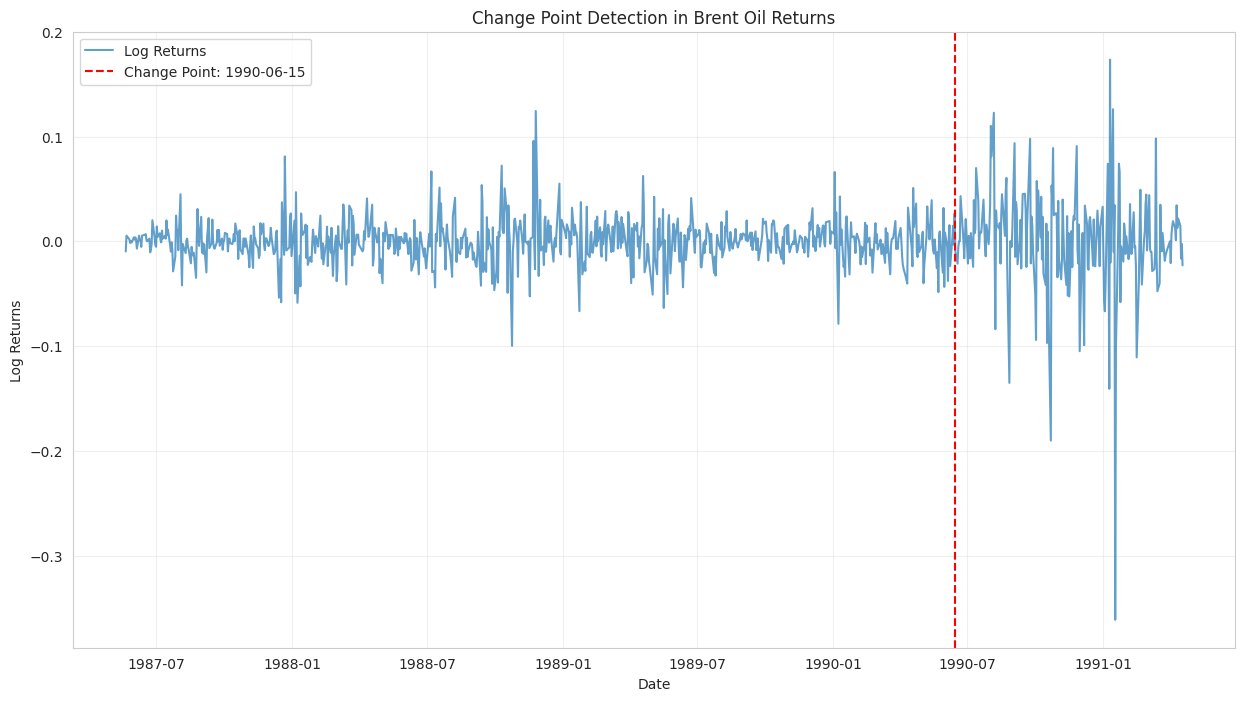

In [7]:
# Visualize the change point
plt.figure(figsize=(15, 8))
plt.plot(dates_subset, values_subset, alpha=0.7, label='Log Returns')
plt.axvline(change_date, color='red', linestyle='--', 
           label=f'Change Point: {change_date.date()}')
plt.title('Change Point Detection in Brent Oil Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Quantify the Impact

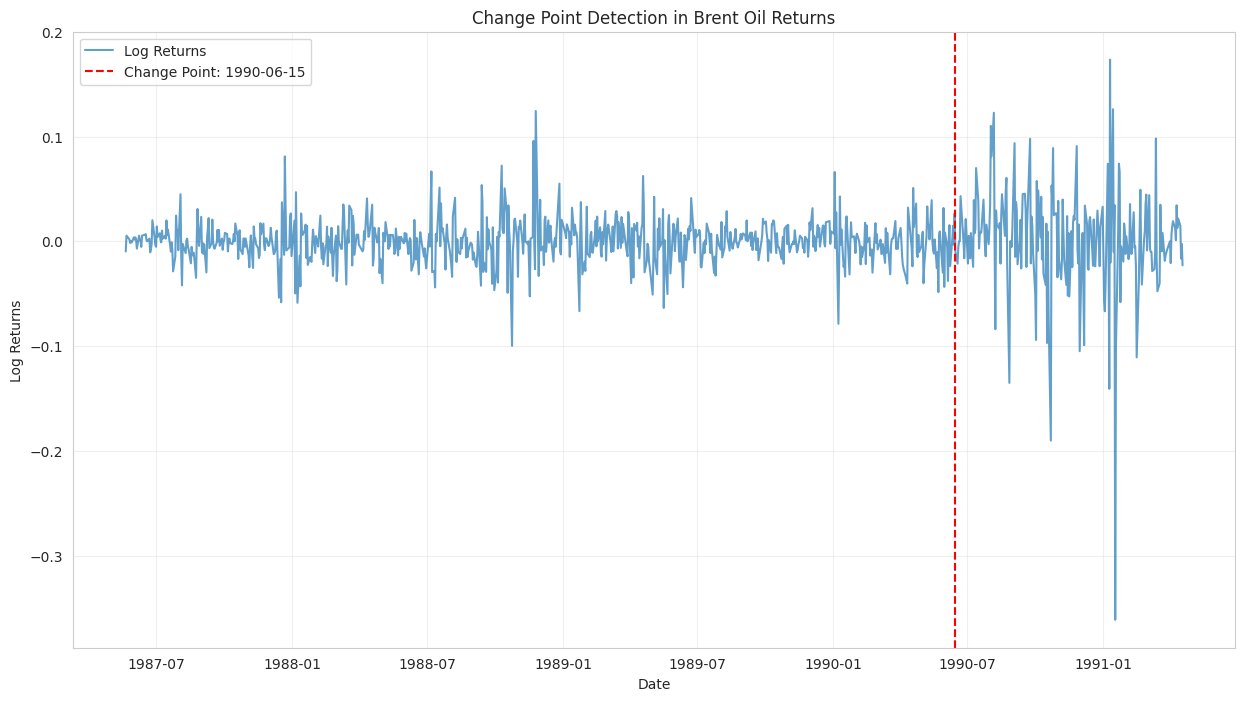

In [8]:
# Visualize the change point
plt.figure(figsize=(15, 8))
plt.plot(dates_subset, values_subset, alpha=0.7, label='Log Returns')
plt.axvline(change_date, color='red', linestyle='--', 
           label=f'Change Point: {change_date.date()}')
plt.title('Change Point Detection in Brent Oil Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()